# Bayesian network creation
The use of the package is focused on the `BayesianNetwork` class. The two main ways of creating new networks are using the constructor, in case you already have a graph structure or parameters, and learning it from data using `fit` function.

## Using the constructor
If you already have a graph structure and the network parameters (or joint probability distribution) in the right formats, it is posible to use the constructor for building the network. The graph structure is represented using a `DiGraph` object from the `networkx` package.

In [1]:
from networkx import DiGraph

graph = DiGraph()
graph.add_nodes_from([1, 2])
graph.add_edges_from([(1, 2)])

### Gaussian case
The network parameters are represented with a dictionary where the keys are the identifiers of the nodes (they must be the same as in the `DiGraph` object) and the values are `GaussianNode` objects. `GaussianNode` is just a named tuple with four elements: `uncond_mean`, `cond_var`, `parents` and `parents_coeffs`. For each node, these elements represent the unconditional mean, conditional variance, parents and coefficients in the regression of the node on its parents.

In [5]:
parameters = {1: {'uncond_mean': 0, 'cond_var': 1, 'parents_coeffs': [], 'parents': []}, 
              2: {'uncond_mean': 0, 'cond_var': 1, 'parents_coeffs': [1], 'parents': [1]}}

### Discrete case

In the discrete case, we use `pgmpy` as the core package, and the parameters of the network are `pgmpy.TabularCPD` objects. Suppose node 1 has 3 possible categories 0, 1 and 2 and its table CPD is

|     |     |
|-----|-----|
|1(0) |0.3  |
|1(1) |0.3  |
|1(2) |0.4  |

and node 2 also has 3 possible categories and its table CPD is 

|1    |1(0) |  1(1)| 1(2)  |
|-----|-----|------|-------|
|2(0) |0.1  |  0.1 |  0.1  |
|2(1) |0.1  |  0.1 |  0.1  |
|2(2) |0.8  |  0.8 |  0.8  |

In [3]:
from pgmpy.factors.discrete.CPD import TabularCPD

cpd1 = TabularCPD(1, 3, [[0.3], [0.3], [0.4]])
cpd2 = TabularCPD(2, 3, [[0.1,0.1,0.1], [0.1,0.1,0.1],[0.8,0.8,0.8]], evidence=[1], evidence_card=[3])

parameters = {1: cpd1, 2: cpd2}

Once you have both the `graph` and `parameters`, the network can be instantiated the usual way. In the discrete case, the user needs to pass as an argument `data_type='discrete'` and in the continuous case `data_type='continuous'`.

In [2]:
import sys
sys.path.append('/home/javier/Documents/master/tfm/neurogenpy')
from neurogenpy import BayesianNetwork

bn = BayesianNetwork(graph=graph, parameters=parameters, data_type='continuous')

print('Nodes:', bn.graph.nodes())
print('Edges:', bn.graph.edges())


NameError: name 'parameters' is not defined

## Learning the full network from data
As said before, it is possible to learn the structure and parameters of a Bayesian network from data. First of all, you should create a `pandas DataFrame` from your data with the following structure:

| Instances  |    Feature 1 |    Feature 2 | ... |    Feature N |
|------------|:------------:|:------------:|:---:|:------------:|
| Instance 1 | $Value_{11}$ | $Value_{12}$ | ... | $Value_{1N}$ |
| Instance 2 | $Value_{21}$ | $Value_{22}$ | ... | $Value_{2N}$ |
| ...        |     ...      |       ...    | ... |       ...    |
| Instance n | $Value_{n1}$ | $Value_{n2}$ | ... | $Value_{nN}$ |

In our example, we create it by reading a CSV file.

In [4]:
import pandas as pd

df_cont = pd.read_csv('df.csv')

Once data is in the correct format, there are two ways for learning the network: using arguments of `fit` function or using particular `LearnStructure` and `LearnParameters` subclasses. They are analogous and we particularly recommend the first one as it is simpler.

### Set the structure and parameter learning methods using arguments
Once you have read the file, you can fit it using the `fit` method and setting the structure learning algorithm, estimation method.

In [6]:
df = df_cont.apply(lambda col: pd.cut(col,
                                 bins=[-float('inf'), 2 ** (-0.2) * col.mean(),2 ** 0.2 * col.mean(), float('inf')],
                                 labels=['inh', 'no-c', 'act']))
print(df.dtypes)

print(df.head())

bn = BayesianNetwork().fit(df, data_type='discrete', estimation='mle', algorithm='cl')

print(bn.graph)

C15orf27        category
PGBD5           category
A_23_P64051     category
ATP5G1          category
RAB33B          category
                  ...   
MAPK10          category
ADCY10P1        category
TRAF3IP3        category
LOC100132014    category
ARHGAP1         category
Length: 199, dtype: object
  C15orf27 PGBD5 A_23_P64051 ATP5G1 RAB33B A_24_P485271  CREM  DLX2 OR2B3  \
0     no-c  no-c        no-c   no-c   no-c         no-c  no-c  no-c   inh   
1     no-c  no-c        no-c   no-c    act         no-c  no-c  no-c   inh   
2     no-c  no-c        no-c   no-c    act         no-c  no-c  no-c   inh   
3     no-c  no-c        no-c   no-c    act          act  no-c  no-c   inh   
4     no-c  no-c        no-c   no-c   no-c         no-c  no-c  no-c   inh   

  A_24_P713312  ... A_24_P934744 FCHSD2 LOC728836 A_32_P208978 GAGE10 MAPK10  \
0         no-c  ...         no-c   no-c      no-c         no-c    inh   no-c   
1         no-c  ...          act   no-c       act         no-c   no-c   no-

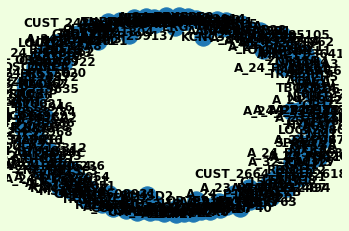

In [8]:

import networkx as nx
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
nx.draw(bn.graph, with_labels=True, font_weight='bold')

ax.set_facecolor('#f0ffe0')
ax.axis('off')
fig.set_facecolor('#f0ffe0')
plt.show()

Additional parameters for the structure learning or parameters estimation algorithm can be provided too.

In [11]:
bn = BayesianNetwork().fit(df_cont, data_type='continuous', estimation='mle', algorithm='cl')

print(bn.graph)

    C15orf27         PGBD5        A_23_P64051        ATP5G1      
 Min.   :2.193   Min.   :5.600   Min.   :1.546   Min.   : 7.805  
 1st Qu.:3.482   1st Qu.:6.151   1st Qu.:2.177   1st Qu.: 9.158  
 Median :3.836   Median :6.326   Median :2.422   Median : 9.401  
 Mean   :3.857   Mean   :6.358   Mean   :2.460   Mean   : 9.349  
 3rd Qu.:4.223   3rd Qu.:6.527   3rd Qu.:2.689   3rd Qu.: 9.587  
 Max.   :5.331   Max.   :7.359   Max.   :4.191   Max.   :10.532  
     RAB33B       A_24_P485271        CREM            DLX2      
 Min.   :3.129   Min.   :1.734   Min.   :5.064   Min.   :3.432  
 1st Qu.:3.524   1st Qu.:4.168   1st Qu.:5.677   1st Qu.:4.088  
 Median :3.788   Median :4.841   Median :5.899   Median :4.318  
 Mean   :3.860   Mean   :4.647   Mean   :5.849   Mean   :4.343  
 3rd Qu.:4.055   3rd Qu.:5.165   3rd Qu.:6.021   3rd Qu.:4.602  
 Max.   :5.098   Max.   :6.491   Max.   :6.810   Max.   :5.447  
     OR2B3         A_24_P713312     A_32_P5148         BSCL2      
 Min.   :0.6831 

    C15orf27    PGBD5 A_23_P64051    ATP5G1  RAB33B A_24_P485271     CREM
0    3.66370 6.772300     2.16360  9.625600 3.82320       4.8488 5.856117
1    3.93015 6.671367     2.18205  9.499975 4.43540       5.0290 5.946083
2    4.32885 6.726933     2.24860  9.677875 4.44775       5.0082 5.653283
3    4.36225 6.975767     2.31065  9.568875 4.44450       5.6768 5.976317
4    4.13350 6.754800     2.66450 10.061325 3.60050       5.1801 5.961300
5    4.05450 6.871000     2.35505  9.902225 3.46075       5.6782 6.128217
6    4.15090 6.815633     2.50955  9.813400 3.61360       5.4301 6.243850
7    3.87520 7.194267     2.33215 10.105200 4.24535       6.0395 6.245867
8    4.13895 6.669133     2.29945  9.471950 4.46865       4.8109 5.667767
9    4.21615 7.021100     1.95425 10.136300 4.46600       5.4148 5.938667
10   3.85730 7.023500     2.08660  9.900450 4.62935       5.4156 5.969450
11   4.04570 6.819133     2.20185  9.808175 3.62825       5.1620 5.801017
12   3.83160 6.601133     2.95115  9.3

R[write to console]: Error in check.test(test, x) : 
  test 'mi' may be used with discrete data only.

R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 

Error getting a correct network structure. There is no DAG available for this data and algorithm.


TypeError: object of type 'NoneType' has no len()

### Instance a particular `LearnStructure` or `LearnParameters` subclass
Another option is to use the desired subclass of `LearnStructure` or `LearnParameters`.

In [ ]:
from neurogenpy import PC, GaussianMLE

pc = PC(df, data_type='continuous')

mle = GaussianMLE(df)

bn = BayesianNetwork().fit(algorithm=pc, estimation=mle)

## Combinations
You can use combinations of the above methods to build your network. If you are only interested in the graph structure, it is possible to just learn the structure and not the parameters by not providing any value for the attribute `estimation`.

In [ ]:
bn = BayesianNetwork().fit(df, data_type='continuous', algorithm='pc')

On the other hand, if you already have a graph structure and want to learn the parameters, you can provide it in the constructor or load it before calling `fit` with `skip_structure` set to `True`.

In [ ]:
bn = BayesianNetwork(graph=graph)
bn.fit(df, data_type='continuous', estimation='mle')

bn = BayesianNetwork().load('adjacency_matrix.csv')
bn.fit(df, data_type='continuous', estimation='mle')